In [128]:
import muon
import re
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
import os
os.chdir("C:\\Users\\dan94\\OneDrive - University College London\\UCL_Senior_Research_Fellow\\RIPs_Vincent_project\\qiu_reanalysis")
os.environ["R_HOME"] = "C:\\Users\\dan94\\miniconda3\\envs\\scrnaseq\\Lib\\R\\"
import rpy2
import anndata2ri #has to be version 1.1 to not throw error, so check this is the case
from rpy2.robjects import r
anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [129]:
import decoupler as dc

In [333]:
degs_df = pd.read_csv("monocyte_deg_directionality.csv")

In [334]:
degs_df

,Unnamed: 0,gene,log2fc_status,condition,log2fc,padj,sig
0,1,A1BG,Up in S only,NS,-1.667337,1.000000e+00,p >= 0.05
1,2,A1BG,Up in S only,S,0.137513,3.702037e-02,p < 0.05
2,3,A1BG,Up in S only,HC,0.000000,1.000000e+00,p >= 0.05
3,4,AAED1,Down in S only,NS,-0.414496,1.000000e+00,p >= 0.05
4,5,AAED1,Down in S only,S,-0.605488,3.197237e-09,p < 0.05
...,...,...,...,...,...,...,...
7420,7421,ZSWIM7,Up in S only,S,0.487499,3.418682e-10,p < 0.05
7421,7422,ZSWIM7,Up in S only,HC,0.000000,1.000000e+00,p >= 0.05
7422,7423,ZYX,Down in S only,NS,-0.215609,1.000000e+00,p >= 0.05
7423,7424,ZYX,Down in S only,S,-0.394880,8.270660e-14,p < 0.05


In [337]:
#if dealing with a table that doesn't need any filtering, raname to degs and proceed to processing
degs = degs_df

In [338]:
degs = degs_df[degs_df['log2fc_status'].isin(['Down in NS & up in S', "Up in S only"])]

In [339]:
#if using the directionality gene list, need to filter out genes so 
#only one is represented (so just filter on one condition)
#the condition is important, as log2FC will be up in one group but down in the other
degs = degs[degs["condition"] == "S"]

In [ ]:
degs['gene'] = degs['Unnamed: 0'].str.replace(r'\...\d+$', '', regex=True)

In [340]:
# Ensure it's indexed by gene names
degs = degs.dropna(subset=['log2fc'])  # Remove genes without log2fc
degs = degs.set_index('gene')

# Create a log2FC vector (used as "pseudo-expression")
logfc_vector = degs['log2fc']

In [341]:
# Reshape into 1 sample x n genes
X = logfc_vector.values.reshape(1, -1)
genes = logfc_vector.index.tolist()

# Create AnnData object
adata_logfc = ad.AnnData(X=X)
adata_logfc.var_names = genes
adata_logfc.obs_names = ['logfc_sample']

In [320]:
collectri = dc.op.collectri(organism='human')
collectri

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


In [99]:
#saving the collectri database so i can inspect it in excel
collectri.to_csv("collectri_transcription_factors.csv", index = False)

In [342]:
# Run ULM model (linear model, good for logFC input)
dc.mt.ulm(
    data=adata_logfc,
    net=collectri,
    verbose=True
)

ulm - Running ulm
Extracted omics mat with 1 rows (observations) and 808 columns (features)
Network adjacency matrix has 287 unique features and 106 unique sources
ulm - fitting 106 univariate models of 808 observations (targets) with 806 degrees of freedom
ulm - adjusting p-values by FDR
ulm - done


In [343]:
# Extract TF scores
score = dc.pp.get_obsm(adata=adata_logfc, key='score_ulm')
score

AnnData object with n_obs × n_vars = 1 × 106
    obsm: 'score_ulm', 'padj_ulm'

In [344]:
#extract p values
padj = dc.pp.get_obsm(adata=adata_logfc, key = "padj_ulm")

In [345]:
score_df = score.to_df()
padj_df = padj.to_df()

In [346]:
# Transpose so TFs become rows, metrics become columns
score_df_t = score_df.T
padj_df_t = padj_df.T

# Rename columns to meaningful names
score_df_t.columns = ['logfc_sample']
padj_df_t.columns = ['padj']

# Join side by side on TF names (the index)
combined_df = score_df_t.join(padj_df_t)

print(combined_df)

      logfc_sample      padj
AHR      -0.452142  0.942106
AP1      -0.174767  0.997332
AR       -0.389771  0.959728
ATF1     -0.042859  0.999249
ATF2     -1.569720  0.904687
...            ...       ...
USF2      0.894342  0.929177
VDR      -0.169293  0.997332
WT1       0.006321  0.999249
XBP1      0.000941  0.999249
YY1       0.335499  0.976970

[106 rows x 2 columns]


In [347]:
combined_df.to_csv("TFs_and_padj_mono_up_S_down_or_flat_NS.csv")

In [348]:
#save the score dataframe to then use in R for plotting
score_df.to_csv("monocyte_TFs_up_S_down_or_flat_NS.csv")

In [349]:
adata_df = adata_logfc.to_df()

In [350]:
score_df.T.sort_values(by='logfc_sample', ascending=False).head(20).index.tolist()

['E2F4',
 'HR',
 'CEBPB',
 'FOXO3',
 'IRF8',
 'PDX1',
 'ESR1',
 'NFE2L2',
 'NR1I2',
 'GATA4',
 'SREBF1',
 'TCF4',
 'NRF1',
 'STAT5A',
 'PPARD',
 'USF1',
 'FOXA2',
 'SPI1',
 'USF2',
 'FOXO1']

In [351]:
# Step 1: Get list of DEGs used in your ULM input
deg_list = genes # assuming genes are in index

# Step 2: Filter the collectri network to only include DEG targets
filtered_net = collectri[collectri['target'].isin(deg_list)]


In [352]:
score_df

,AHR,AP1,AR,ATF1,ATF2,ATF3,ATF6,CEBPA,CEBPB,CEBPG,...,TCF7L2,TFAP2A,TP53,TP63,USF1,USF2,VDR,WT1,XBP1,YY1
logfc_sample,-0.452142,-0.174767,-0.389771,-0.042859,-1.56972,0.004903,-0.995863,0.245617,1.604654,0.804262,...,-0.266383,-2.161202,-0.899631,-0.862461,0.960622,0.894342,-0.169293,0.006321,0.000941,0.335499


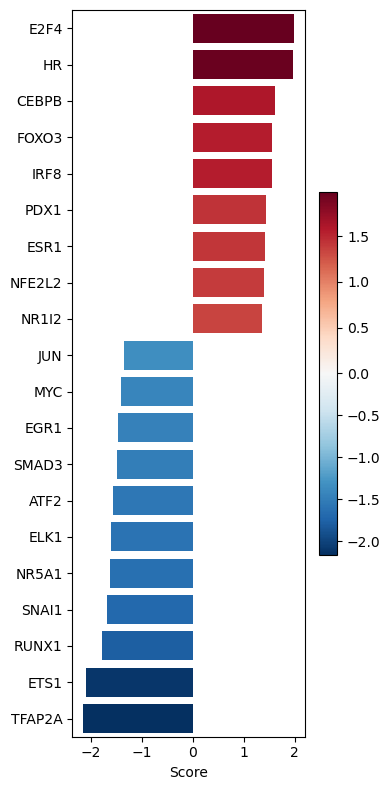

In [353]:
#i make barplot in R, this is just to quickly see what is top
dc.pl.barplot(
    data=score_df,
    name = 'logfc_sample',
    top = 20,
    figsize=(4, 8)
)

In [354]:
top5_up = score_df.T.sort_values(by='logfc_sample', ascending=False).head(5).index.tolist()
top5_down = score_df.T.sort_values(by='logfc_sample', ascending=True).head(5).index.tolist()
top5_combined = top5_up + top5_down

In [355]:
top10_up = score_df.T.sort_values(by='logfc_sample', ascending=False).head(10).index.tolist()

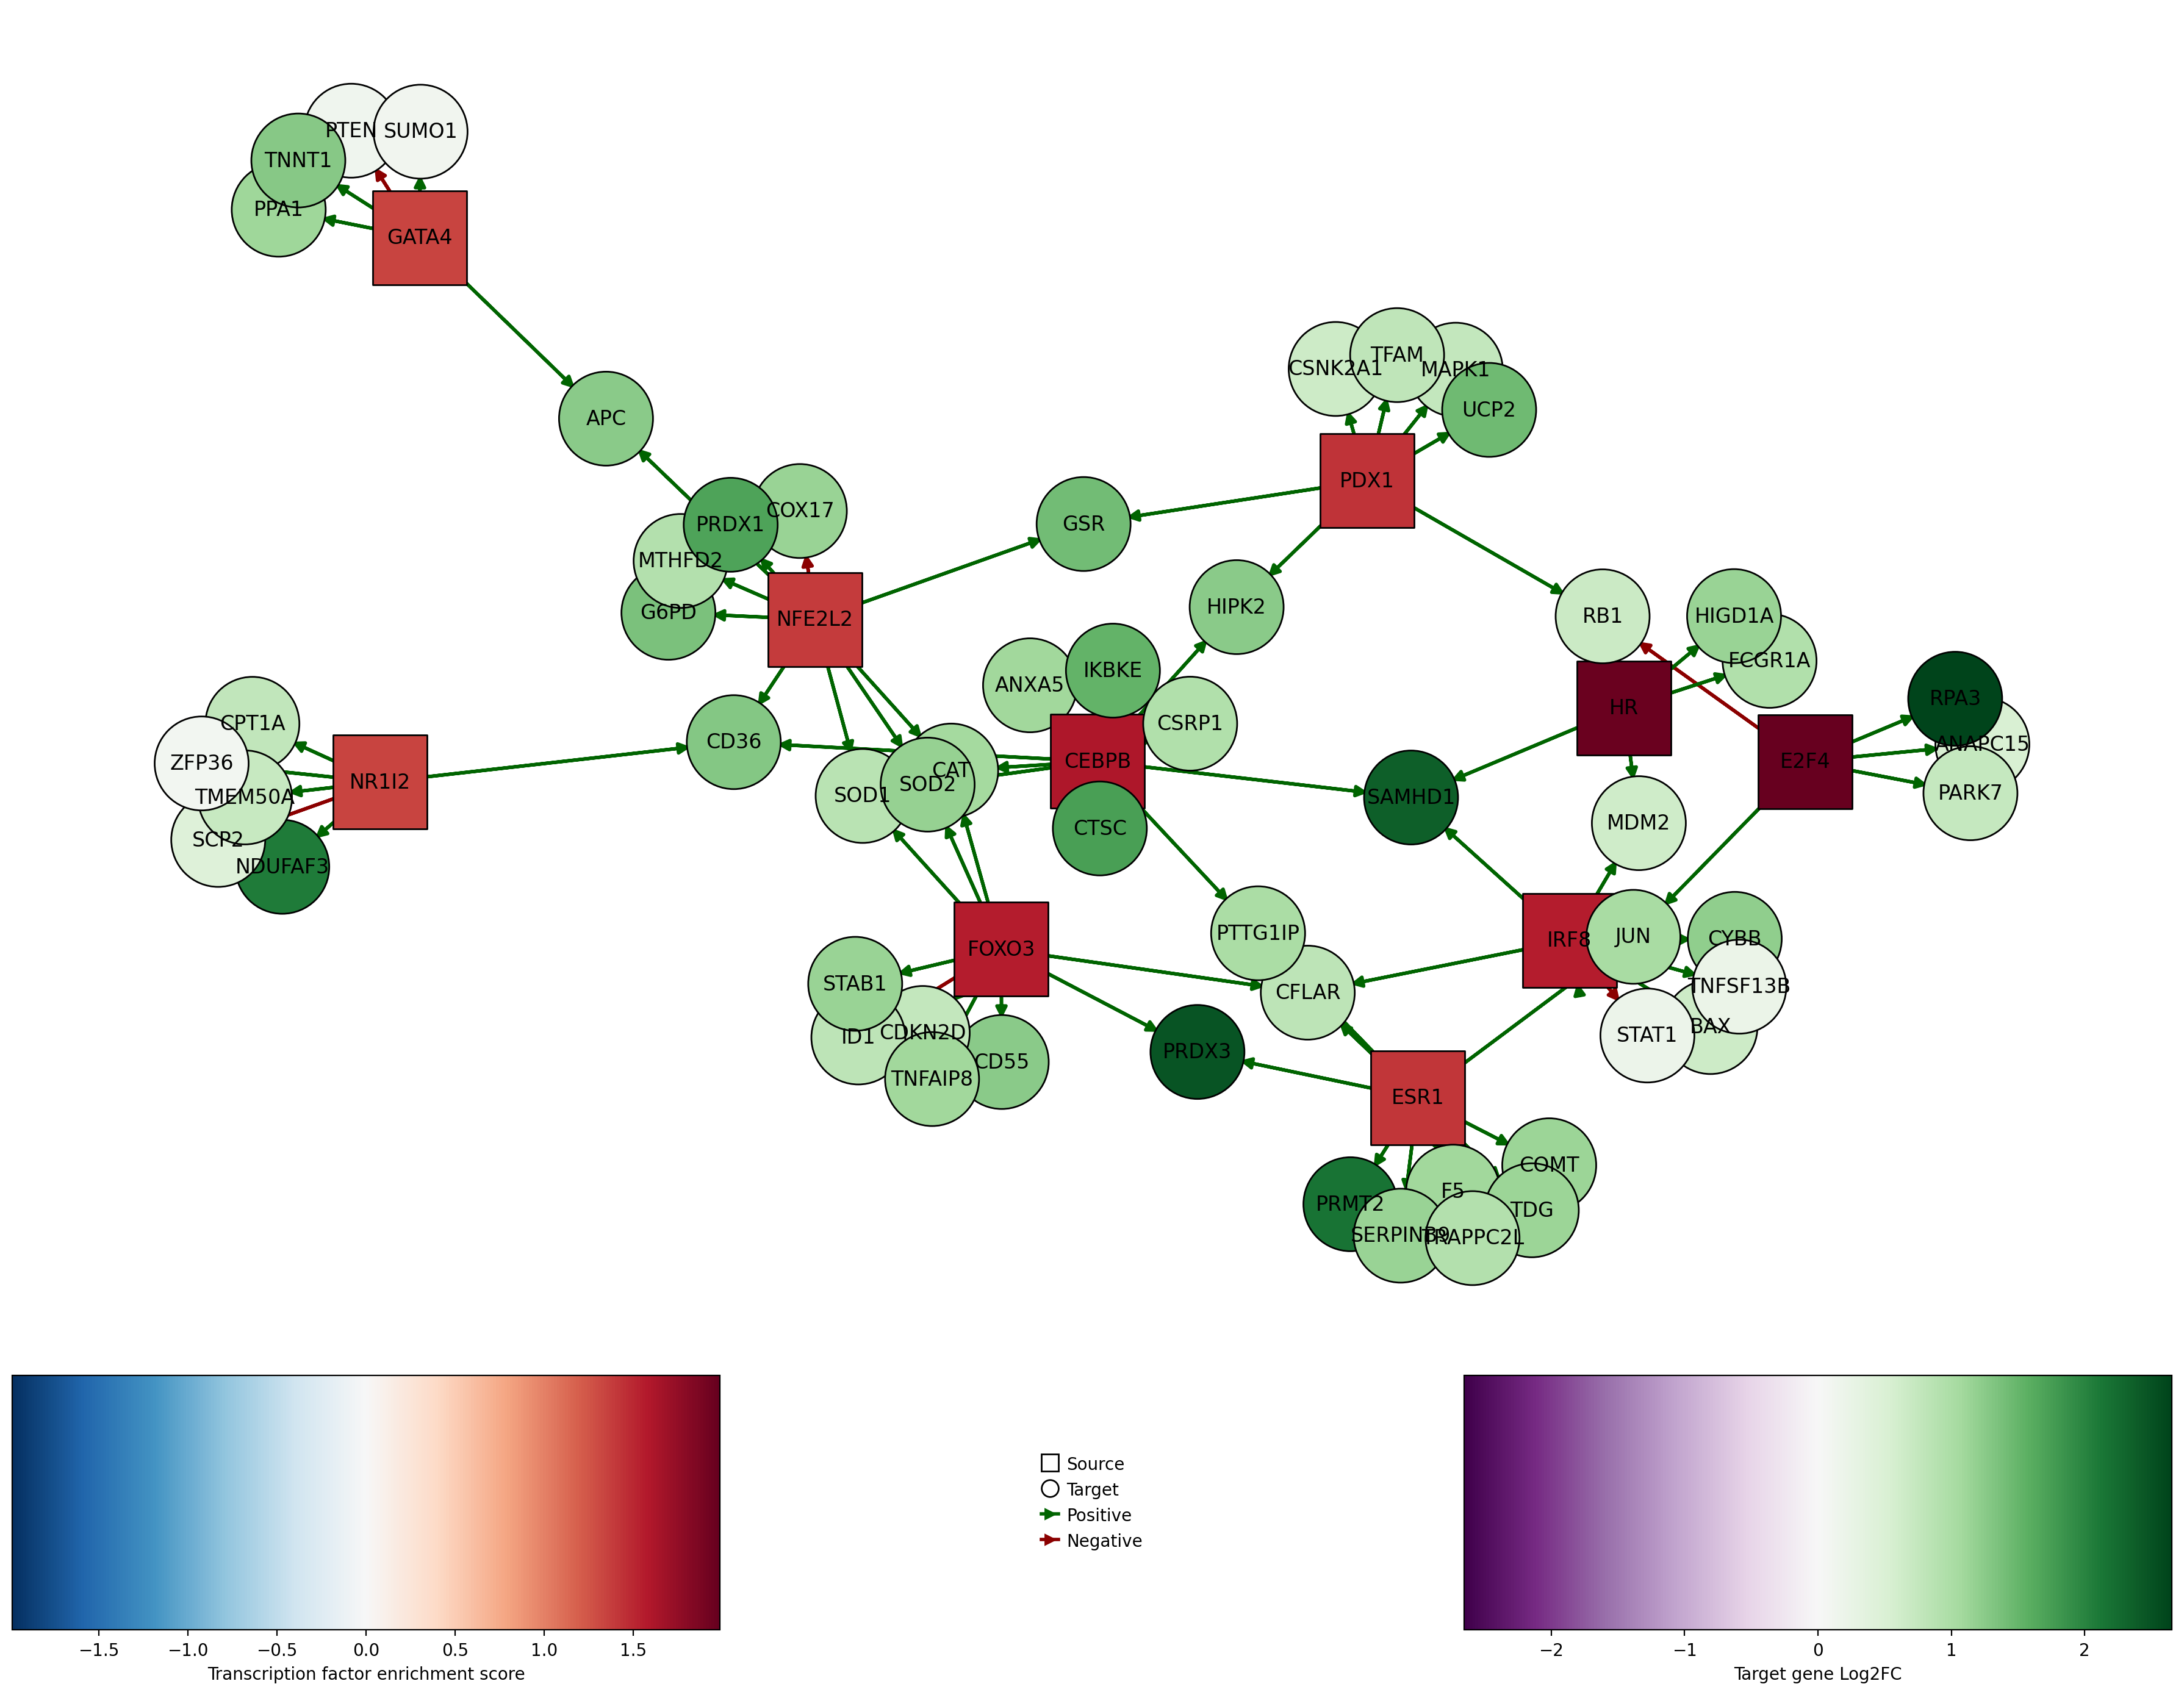

In [356]:
dc.pl.network(
    data=adata_df,
    score=score_df,
    net=filtered_net,
    sources=top10_up,
    targets=10,
    size_node=250,
    size_label=3,
    vcenter=True,
    s_label="Transcription factor enrichment score",
    t_label="Target gene Log2FC",
    by_abs=True,
    t_cmap="PRGn",
    layout = "fr",
    figsize=(18,14),
    save = "network_mono_up_S_down_or_flat_NS.png", dpi = 200
)